## Airbnb new user bookings

### <span style="color:red">1.Know the topic

#### Using history data to predict the booking country of future new user

In [ ]:
#### y is multi-categorical data

### <span style="color:red">2.Package import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
import seaborn as sns
sns.set_style("darkgrid")
LARGE_FIGSIZE = (20,16)
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1)

### <span style="color:red">3.Data upload

In [4]:
users = pd.read_csv('data/train_users_2.csv',parse_dates=[1,2,3]) 
countries = pd.read_csv("data/countries.csv")
sessions = pd.read_csv("data/sessions.csv")

In [5]:
users.drop('date_first_booking',axis=1,inplace=True)

In [6]:
#copy the original data
users_original = users.copy()
countries_original = countries.copy()
sessions_original = sessions.copy()

### <span style="color:red">4.Data description

In [7]:
countries.head()
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [6]:
print(users.shape)

(213451, 15)


In [9]:
print(sessions.shape)

(10567737, 6)


### Session dataset:

### <span style="color:red">5.Data cleaning

#### missing value

In [10]:
sessions.isnull().sum(axis=0)

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [11]:
#delete the row which user_id is null
sessions.dropna(subset=['user_id'], inplace=True)

In [12]:
#get the action_type and number which the action is null
sessions[sessions.action.isnull()].action_type.value_counts()

message_post    79480
Name: action_type, dtype: int64

In [13]:
##get the action_detail and number which the action is null
sessions[sessions.action.isnull()].action_detail.value_counts()

message_post    79480
Name: action_detail, dtype: int64

In [14]:
# all the null values point to the same feature:message_post，so, to fill it into the null actions
sessions.loc[sessions.action.isnull(),'action'] = 'message_post'

In [15]:
sessions.isnull().sum(axis=0)
#action_type and action_detail have the same number of null

user_id                0
action                 0
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

#### cause action_type and action_detail belong to action, then fill the missing value as follows:

In [16]:
#fill the value in null action_type row and action_type col with the value in null action_type row and action col
sessions.loc[sessions.action_type.isnull(),'action_type']=sessions.loc[sessions.action_type.isnull(),'action']

In [17]:
#fill the value in null action_type row and action_detail col with the value in null action_detail row and action col
sessions.loc[sessions.action_detail.isnull(),'action_detail'] = sessions.loc[sessions.action_detail.isnull(),'action']

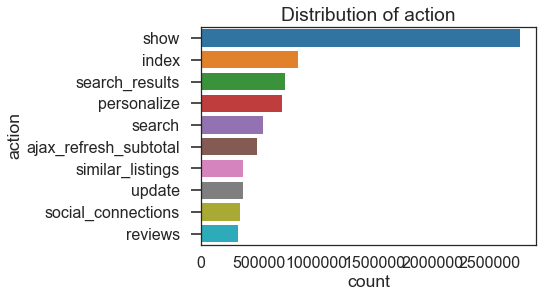

In [18]:
# visualize to get better understanding for action distribution.
sns.countplot(y='action', data=sessions, 
                             order = sessions['action'].value_counts()[:10].index)
plt.title("Distribution of action")
plt.show()
#results:distribution is kind of random, keep all of them

In [19]:
sessions['action'].value_counts()[:10]

show                     2758985
index                     841071
search_results            723124
personalize               704782
search                    533833
ajax_refresh_subtotal     486414
similar_listings          363423
update                    362708
social_connections        337764
reviews                   319318
Name: action, dtype: int64

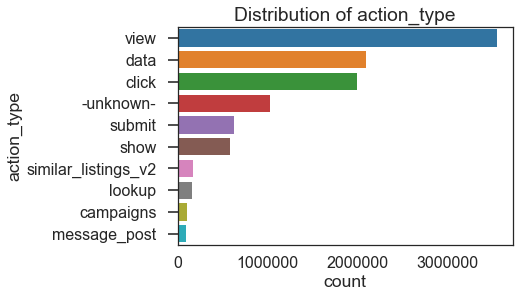

In [20]:
# bar chart for action_type
sns.countplot(y='action_type', data=sessions, 
                             order = sessions['action_type'].value_counts()[:10].index)
plt.title("Distribution of action_type")
plt.show()

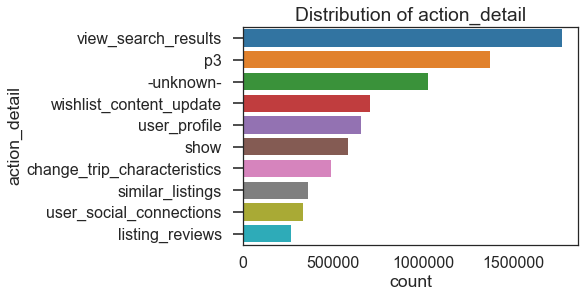

In [21]:
# bar chart for action_detail
sns.countplot(y='action_detail', data=sessions, 
                             order = sessions['action_detail'].value_counts()[:10].index)
plt.title("Distribution of action_detail")
plt.show()

E:\downloads\Anaconada\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


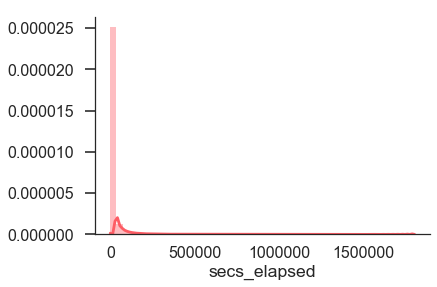

In [22]:
# density plot for secs_elapsed
sns.distplot(sessions.secs_elapsed.dropna(), color='#FD5C64') #drop the null secs_elapsed
plt.xlabel('secs_elapsed')
sns.despine() #Remove the top and right spines from plot(s).
plt.show()
#result:uneven，larger parts are concentrated in range 0，here: we fill null with 0

In [23]:
# from the real meaning, null secs is filled 0
sessions.secs_elapsed.fillna(0, inplace=True)

In [24]:
sessions.isnull().sum()
#no missing value exists

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

### <span style="color:red">6.Feature Engineering
    creating new features in session dataset
    Learn how to deal with multiIndices dataframe:
       ->Reshaping in Pandas:Pivot/Pivot-Table,Stack/Unstack

In [25]:
sessions.head()
#each use_iddifferent actions,aggregation

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,lookup,lookup,Windows Desktop,435.0


In [26]:
session_group = sessions.groupby(['user_id','action','action_type','action_detail'])['secs_elapsed'].\
agg(['sum','mean','max','min'])

In [27]:
session_group.head()

sum  \
user_id    action                action_type      action_detail                           
00023iyk9l ajax_refresh_subtotal click            change_trip_characteristics    1447.0   
           callback              partner_callback oauth_response                    0.0   
           confirm_email         click            confirm_email_link           567165.0   
           dashboard             view             dashboard                      4462.0   
           header_userpic        data             header_userpic                 3198.0   

                                                                                   mean  \
user_id    action                action_type      action_detail                           
00023iyk9l ajax_refresh_subtotal click            change_trip_characteristics     723.5   
           callback              partner_callback oauth_response                    0.0   
           confirm_email         click            confirm_email_link           567165.0   
           dashboard             view             dashboard                      1115.5   
           header_userpic        data             header_userpic                 1599.0   

                                                                                    max  \
user_id    action                action_type      action_detail                           
00023iyk9l ajax_refresh_subtotal click            change_trip_characteristics     836.0   
           callback              partner_callback oauth_response                    0.0   
           confirm_email         click            confirm_email_link           567165.0   
           dashboard             view             dashboard                      2331.0   
           header_userpic        data             header_userpic                 2348.0   

                                                                                    min  
user_id    action                action_type      action_detail                          
00023iyk9l ajax_refresh_subtotal click            change_trip_characteristics     611.0  
           callback              partner_callback oauth_response                    0.0  
           confirm_email         click            confirm_email_link           567165.0  
           dashboard             view             dashboard                       410.0  
           header_userpic        data             header_userpic                  850.0

In [28]:
# groupby, unstack the dataset,reshape the dataframe
session_group_v2 = session_group.unstack([1,2,-1])
#define the columns using for-loop
session_group_v2.columns = ['_'.join(i).rstrip('_') for i in session_group_v2.columns.values]

In [30]:
session_group_v2.head(20)
#magnitude is large, standization

,sum_ajax_refresh_subtotal_click_change_trip_characteristics,sum_callback_partner_callback_oauth_response,sum_confirm_email_click_confirm_email_link,sum_dashboard_view_dashboard,sum_header_userpic_data_header_userpic,sum_index_view_view_search_results,sum_message_post_message_post_message_post,sum_pending_booking_request_pending,sum_personalize_data_wishlist_content_update,sum_requested_view_p5,...,min_acculynk_pin_pad_success_-unknown-_-unknown-,min_deactivated_view_host_standard_suspension,min_special_offer_message_post_message_post,min_deactivate_-unknown-_-unknown-,min_events_-unknown-_-unknown-,min_south-america_-unknown-_-unknown-,min_reactivate_-unknown-_-unknown-,min_update_message_-unknown-_-unknown-,min_wishlists_-unknown-_-unknown-,min_plaxo_cb_-unknown-_-unknown-
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,1447.0,0.0,567165.0,4462.0,3198.0,32712.0,129817.0,0.0,3515.0,40132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0010k6l0om,20110.0,0.0,NaN,970.0,585.0,30107.0,NaN,NaN,135661.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001wyh0pz8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0028jgx1x1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002qnbzfs5,NaN,NaN,14520.0,7603.0,10954.0,NaN,23753.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0031awlkjq,NaN,NaN,NaN,2063.0,719.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0035hobuyj,12201.0,NaN,258735.0,69271.0,1927.0,1123483.0,254087.0,NaN,42378.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00378ocvlh,1703.0,NaN,NaN,11824.0,2878.0,NaN,604179.0,NaN,26639.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00389675gq,22471.0,NaN,NaN,98238.0,1608.0,134711.0,206836.0,NaN,26659.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
session_group_v2.fillna(0,inplace=True) #deal with NAN data，fill 0
session_group_scale = pd.DataFrame(scaler.fit_transform(session_group_v2), columns=session_group_v2.columns,
                                  index=session_group_v2.index)

In [32]:
device_freq = sessions.groupby(['user_id','device_type'])['device_type'].count().unstack(-1)

In [33]:
action_freq = sessions.groupby(['user_id','action'])['action'].count().unstack(-1)

In [34]:
device_freq.fillna(0,inplace=True)
action_freq.fillna(0,inplace=True)

In [35]:
device_freq.columns = list(map(lambda i: 'device_type_count'+str(i), device_freq.columns))
action_freq.columns = list(map(lambda i: 'action_freq_count'+str(i), action_freq.columns))

In [37]:
device_freq.head()

,device_type_count-unknown-,device_type_countAndroid App Unknown Phone/Tablet,device_type_countAndroid Phone,device_type_countBlackberry,device_type_countChromebook,device_type_countLinux Desktop,device_type_countMac Desktop,device_type_countOpera Phone,device_type_countTablet,device_type_countWindows Desktop,device_type_countWindows Phone,device_type_countiPad Tablet,device_type_countiPhone,device_type_countiPodtouch
user_id,,,,,,,,,,,,,,
00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001wyh0pz8,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028jgx1x1,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002qnbzfs5,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0,0.0


In [38]:
action_freq.head()

,action_freq_count10,action_freq_count11,action_freq_count12,action_freq_count15,action_freq_countabout_us,action_freq_countaccept_decline,action_freq_countaccount,action_freq_countacculynk_bin_check_failed,action_freq_countacculynk_bin_check_success,action_freq_countacculynk_load_pin_pad,...,action_freq_countview,action_freq_countviews,action_freq_countviews_campaign,action_freq_countviews_campaign_rules,action_freq_countwebcam_upload,action_freq_countweibo_signup_referral_finish,action_freq_countwhy_host,action_freq_countwidget,action_freq_countwishlists,action_freq_countzendesk_login_jwt
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028jgx1x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002qnbzfs5,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# join the session_detail_pcts,device_freq,action_freq according to user_id(the same column),
X_session = pd.concat([session_group_scale,device_freq,action_freq],axis=1)


In [40]:
X_session.head()
#now transform the original categorical table into a numerical table

,sum_ajax_refresh_subtotal_click_change_trip_characteristics,sum_callback_partner_callback_oauth_response,sum_confirm_email_click_confirm_email_link,sum_dashboard_view_dashboard,sum_header_userpic_data_header_userpic,sum_index_view_view_search_results,sum_message_post_message_post_message_post,sum_pending_booking_request_pending,sum_personalize_data_wishlist_content_update,sum_requested_view_p5,...,action_freq_countview,action_freq_countviews,action_freq_countviews_campaign,action_freq_countviews_campaign_rules,action_freq_countwebcam_upload,action_freq_countweibo_signup_referral_finish,action_freq_countwhy_host,action_freq_countwidget,action_freq_countwishlists,action_freq_countzendesk_login_jwt
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,-0.172316,-0.095917,1.938535,-0.084651,-0.006397,-0.264978,0.377594,-0.099304,-0.235104,1.348203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0010k6l0om,0.045244,-0.095917,-0.347223,-0.117033,-0.075753,-0.272920,-0.250940,-0.099304,0.705658,-0.085831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001wyh0pz8,-0.189184,-0.095917,-0.347223,-0.126028,-0.091281,-0.364708,-0.250940,-0.099304,-0.260128,-0.085831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028jgx1x1,-0.189184,-0.095917,-0.347223,-0.126028,-0.091281,-0.364708,-0.250940,-0.099304,-0.260128,-0.085831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002qnbzfs5,-0.189184,-0.095917,-0.288705,-0.055524,0.199470,-0.364708,-0.135935,-0.099304,-0.260128,-0.085831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Users dataset:

In [41]:
users.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2.01E+13,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2.01E+13,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2.01E+13,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2.01E+13,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2.01E+13,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
users.set_index(['id'],inplace=True)

In [43]:
users.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
id,,,,,,,,,,,,,,
gxn3p5htnn,2010-06-28,2.01E+13,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
820tgsjxq7,2011-05-25,2.01E+13,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
4ft3gnwmtx,2010-09-28,2.01E+13,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
bjjt8pjhuk,2011-12-05,2.01E+13,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
87mebub9p4,2010-09-14,2.01E+13,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [8]:
df_Y = users['country_destination']
users = users.drop('country_destination',axis=1)

### <span style="color:red">Data cleaning

In [9]:
users.isnull().sum()

date_account_created           0
timestamp_first_active         0
gender                         0
age                        87990
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6065
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [10]:
users.dtypes

date_account_created       datetime64[ns]
timestamp_first_active             object
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
dtype: object

In [11]:
# signup_flow is not numerical
users.signup_flow=users.signup_flow.astype('object')

In [12]:
#deal with gender
users.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [49]:
users.head(10)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,
gxn3p5htnn,2010-06-28,2.01E+13,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,2011-05-25,2.01E+13,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,2010-09-28,2.01E+13,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,2011-12-05,2.01E+13,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,2010-09-14,2.01E+13,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
osr2jwljor,2010-01-01,2.01E+13,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome
lsw9q7uk0j,2010-01-02,2.01E+13,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari
0d01nltbrs,2010-01-03,2.01E+13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari
a1vcnhxeij,2010-01-04,2.01E+13,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari


In [13]:
users.age.dropna().describe()
#min 1, max 2014, unnormal

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [ ]:
#check distribution of age
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()
plt.show()

In [14]:
# make the numerical age into categorical data
age = users.age
age.fillna(-1, inplace = True)
div = 15
def get_age(age):
    if age < 0:
        return 'NA' 
    elif (age < div):
        return div 
    elif (age <= div * 2):
        return div*2 
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical' 

users['age_bucket'] = np.array([get_age(x) for x in age]).astype('object')
users.drop('age',axis=1,inplace=True)

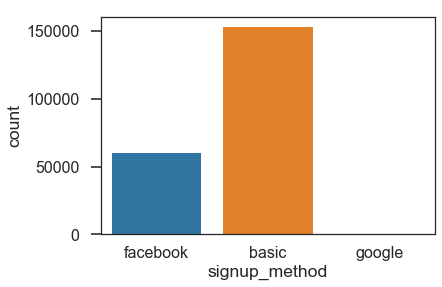

In [15]:
# bar plot for signup_method
sns.countplot(users.signup_method.dropna())
plt.xlabel('signup_method')
plt.show()

In [16]:
users.dtypes

date_account_created       datetime64[ns]
timestamp_first_active             object
gender                             object
signup_method                      object
signup_flow                        object
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
age_bucket                         object
dtype: object

In [17]:
obj_vars = users.select_dtypes(include=['object']).columns.values

In [18]:
obj_vars

array(['timestamp_first_active', 'gender', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'age_bucket'], dtype=object)

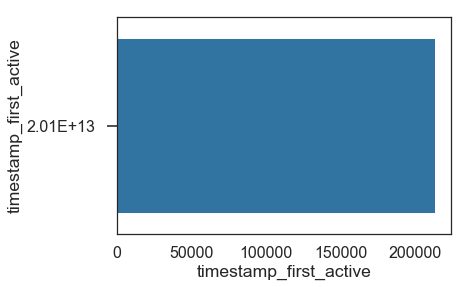

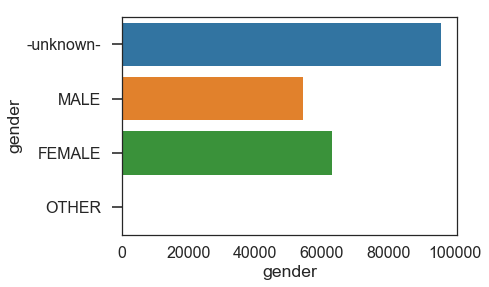

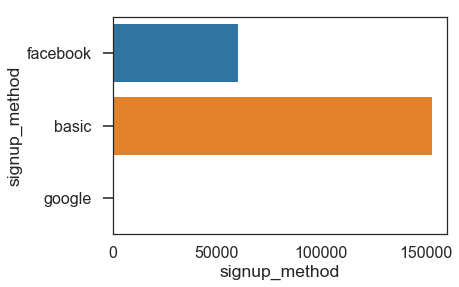

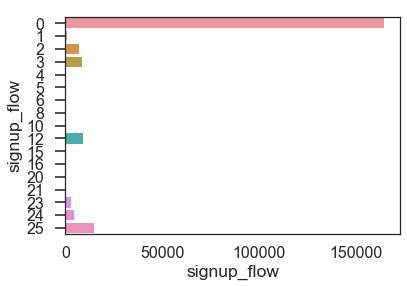

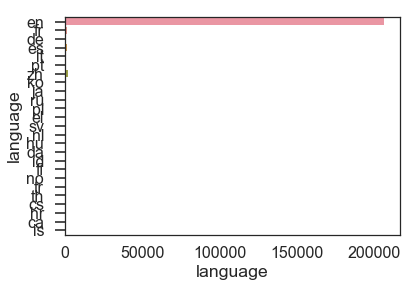

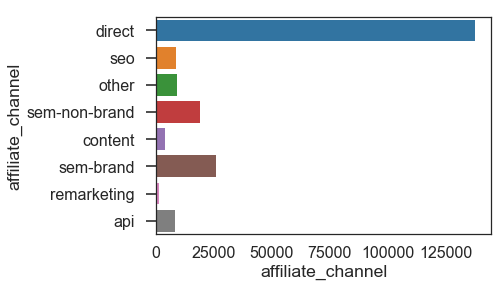

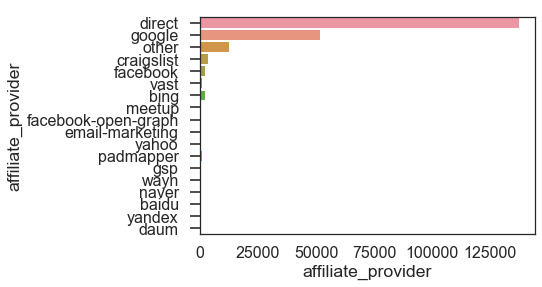

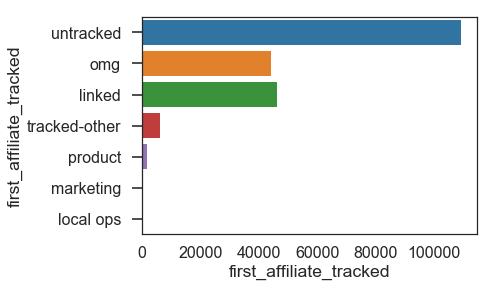

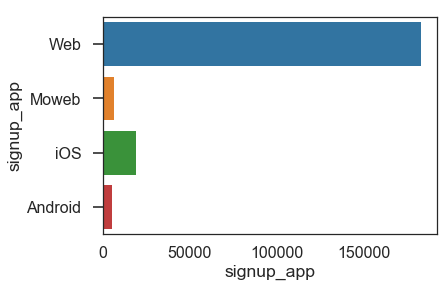

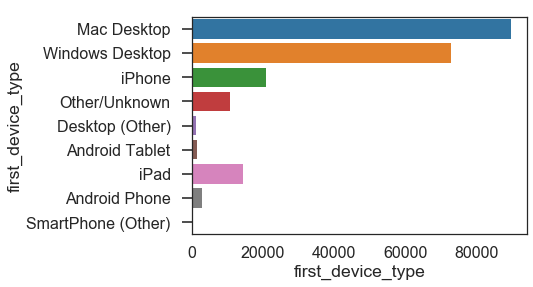

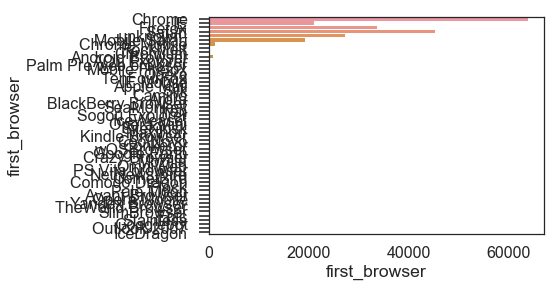

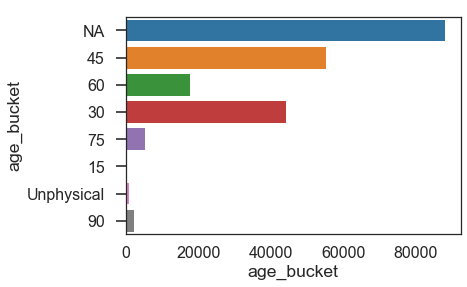

In [19]:
# for loop to check the extreme value/outlier
for i in obj_vars[0:]:
    sns.countplot(y=users[i].dropna())
    plt.xlabel(str(i))
    plt.show()

In [20]:
#check users
users.isna().sum()

date_account_created          0
timestamp_first_active        0
gender                        0
signup_method                 0
signup_flow                   0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked    6065
signup_app                    0
first_device_type             0
first_browser                 0
age_bucket                    0
dtype: int64

In [21]:
users.first_affiliate_tracked.value_counts()

untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

In [22]:
users.first_affiliate_tracked = users.first_affiliate_tracked.fillna("untracked")

In [23]:
#deal with date
users['dac_year'] = users.date_account_created.apply(lambda x: x.year).astype('object')
users['dac_month'] = users.date_account_created.apply(lambda x: x.month).astype('object')
users['dac_weekday'] = users.date_account_created.apply(lambda x: x.weekday()).astype('object')
users.drop(['date_account_created'], axis=1, inplace=True)

In [64]:
users.head()

,timestamp_first_active,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_bucket,dac_year,dac_month,dac_weekday
id,,,,,,,,,,,,,,,
gxn3p5htnn,2.01E+13,-unknown-,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NA,2010,6,0
820tgsjxq7,2.01E+13,MALE,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,45,2011,5,2
4ft3gnwmtx,2.01E+13,FEMALE,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,60,2010,9,1
bjjt8pjhuk,2.01E+13,FEMALE,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,45,2011,12,0
87mebub9p4,2.01E+13,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,45,2010,9,1


In [24]:
#transform object into float/numerical, then transform float into datatime
users["timestamp_first_active"] = users.timestamp_first_active.astype(float)

In [25]:
users.dtypes

timestamp_first_active     float64
gender                      object
signup_method               object
signup_flow                 object
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
age_bucket                  object
dac_year                    object
dac_month                   object
dac_weekday                 object
dtype: object

In [26]:
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], errors='ignore')

In [27]:
users.dtypes

timestamp_first_active     datetime64[ns]
gender                             object
signup_method                      object
signup_flow                        object
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
age_bucket                         object
dac_year                           object
dac_month                          object
dac_weekday                        object
dtype: object

In [28]:
users['tfa_year'] = users.timestamp_first_active.apply(lambda x: x.year).astype('object')
users['tfa_month'] = users.timestamp_first_active.apply(lambda x: x.month).astype('object')
users['tfa_weekday'] = users.timestamp_first_active.apply(lambda x: x.weekday()).astype('object')
users.drop(['timestamp_first_active'], axis=1, inplace=True)

In [29]:
obj_vars = users.select_dtypes(include=['object']).columns.values

In [30]:
obj_vars

array(['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'age_bucket', 'dac_year', 'dac_month',
       'dac_weekday', 'tfa_year', 'tfa_month', 'tfa_weekday'],
      dtype=object)

In [31]:
users_dm = pd.get_dummies(users[obj_vars],prefix=obj_vars)

In [93]:
users_dm(20)

,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,...,dac_weekday_0,dac_weekday_1,dac_weekday_2,dac_weekday_3,dac_weekday_4,dac_weekday_5,dac_weekday_6,tfa_year_1970,tfa_month_1,tfa_weekday_3
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
820tgsjxq7,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,1,1
4ft3gnwmtx,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
bjjt8pjhuk,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
87mebub9p4,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,1
osr2jwljor,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,1
lsw9q7uk0j,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,1
0d01nltbrs,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
a1vcnhxeij,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1


In [32]:
users_dummy = pd.merge(users.drop(obj_vars,axis=1), users_dm, left_index=True,right_index=True)

In [96]:
users_dummy

,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,...,dac_weekday_0,dac_weekday_1,dac_weekday_2,dac_weekday_3,dac_weekday_4,dac_weekday_5,dac_weekday_6,tfa_year_1970,tfa_month_1,tfa_weekday_3
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
820tgsjxq7,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,1,1
4ft3gnwmtx,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
bjjt8pjhuk,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
87mebub9p4,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,1
osr2jwljor,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,1
lsw9q7uk0j,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,1
0d01nltbrs,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
a1vcnhxeij,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1


In [104]:
df_final = pd.merge(users_dummy,X_session,left_index=True,right_index=True,how='left')
df_final_v1 = df_final.fillna(df_final.mean())
df_final.to_csv('train_final_v4.csv',index=None)

### Training Model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [34]:
df_X = users_dummy.copy()
df_y = df_Y[df_Y.index.isin(users_dummy.index)]

In [35]:
df_y.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [36]:
X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.33, random_state=42, stratify=df_y)

In [37]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    """
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1]+ 1))
    T = lb.transform(ground_truth)


    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

### Single Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini',class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
#rank the importance
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns[indices]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))
   

Feature ranking:
1. feature dac_weekday_2 (0.032924)
2. feature first_browser_Chrome (0.032212)
3. feature first_affiliate_tracked_untracked (0.031620)
4. feature dac_weekday_0 (0.031119)
5. feature dac_weekday_1 (0.030143)
6. feature first_affiliate_tracked_linked (0.028715)
7. feature dac_weekday_5 (0.028664)
8. feature dac_weekday_6 (0.027474)
9. feature first_browser_Firefox (0.025896)
10. feature dac_weekday_4 (0.025418)
11. feature dac_weekday_3 (0.024738)
12. feature first_device_type_Mac Desktop (0.023488)
13. feature first_browser_Safari (0.023130)
14. feature first_affiliate_tracked_omg (0.022433)
15. feature first_device_type_Windows Desktop (0.022320)
16. feature gender_FEMALE (0.022207)
17. feature dac_month_5 (0.021953)
18. feature dac_month_4 (0.021825)
19. feature gender_MALE (0.020966)
20. feature dac_month_3 (0.019515)
21. feature dac_year_2013 (0.019473)
22. feature affiliate_channel_sem-brand (0.019269)
23. feature dac_month_2 (0.018567)
24. feature dac_month_6 (0.0

In [45]:
pred_prob_dt = dt.predict_proba(X_val)
#Predict class probabilities of the input samples X.
#The predicted class probability is the fraction of samples of the same class in a leaf.

In [47]:
y_conv = [dt.classes_.tolist().index(k) for k in y_val.tolist()] 
print ('NDCG on Test Set', ndcg_score(y_conv, pred_prob_dt))

NDCG on Test Set 0.6652631209097586


In [48]:
# multi-label confusion matrix
pred_dt = dt.predict(X_val)
pd.crosstab(y_val, pred_dt, rownames=['Actual Destination'], colnames=['Predicted Destination'])
#the results are not good, possible reasons:
#1.model is not good， 2.the evaluation method is not good，3.or the parameters are not good

Predicted Destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
Actual Destination,,,,,,,,,,,,
AU,2,1,1,4,9,8,10,72,1,2,61,7
CA,5,2,12,18,25,11,21,159,8,0,157,53
DE,1,8,4,7,11,18,8,125,4,0,128,36
ES,4,24,9,25,39,22,30,262,17,2,245,63
FR,15,56,26,57,89,51,71,584,16,3,543,147
GB,5,11,9,27,42,26,33,269,9,5,263,68
IT,8,18,20,37,53,24,33,322,10,1,321,89
NDF,309,769,603,1179,1930,1302,1556,21209,521,184,8390,3147
NL,4,3,2,10,11,9,10,94,1,1,79,27


#### Random forest

In [49]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, criterion='gini',class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [50]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns[indices]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))

#the result is more general

Feature ranking:
1. feature first_browser_Chrome (0.028660)
2. feature dac_weekday_2 (0.028541)
3. feature dac_weekday_0 (0.028374)
4. feature dac_weekday_1 (0.028136)
5. feature dac_weekday_3 (0.026875)
6. feature first_affiliate_tracked_untracked (0.026785)
7. feature dac_year_2013 (0.025557)
8. feature dac_weekday_6 (0.025339)
9. feature dac_weekday_4 (0.025113)
10. feature dac_weekday_5 (0.023963)
11. feature dac_month_5 (0.023865)
12. feature first_affiliate_tracked_linked (0.023745)
13. feature dac_month_6 (0.022932)
14. feature age_bucket_45 (0.022592)
15. feature first_browser_Firefox (0.022223)
16. feature first_browser_Safari (0.021010)
17. feature age_bucket_30 (0.020418)
18. feature dac_month_3 (0.020185)
19. feature first_device_type_Mac Desktop (0.020137)
20. feature dac_month_4 (0.020059)
21. feature first_device_type_Windows Desktop (0.019623)
22. feature dac_year_2014 (0.019486)
23. feature dac_year_2012 (0.019024)
24. feature dac_month_2 (0.017657)
25. feature gender_

In [51]:
print ('Number of features to be discarded: ', np.count_nonzero(rf.feature_importances_ < 1e-4))

Number of features to be discarded:  72


In [53]:
import datetime
ds = str(datetime.datetime.now())
important_features = X_train.columns[rf.feature_importances_ >= 1e-4]
ds=ds.replace(":",'')

In [62]:
pd.DataFrame(important_features, columns=['feature']).to_csv(ds+'important_feature_v2.csv',index=None)

In [63]:
important_features

Index(['gender_-unknown-', 'gender_FEMALE', 'gender_MALE', 'gender_OTHER',
       'signup_method_basic', 'signup_method_facebook', 'signup_method_google',
       'signup_flow_0', 'signup_flow_1', 'signup_flow_2',
       ...
       'dac_month_10', 'dac_month_11', 'dac_month_12', 'dac_weekday_0',
       'dac_weekday_1', 'dac_weekday_2', 'dac_weekday_3', 'dac_weekday_4',
       'dac_weekday_5', 'dac_weekday_6'],
      dtype='object', length=110)

In [64]:
pred_prob_clf = rf.predict_proba(X_val)
y_conv = [rf.classes_.tolist().index(k) for k in y_val.tolist()] 

print ('NDCG on Test Set', ndcg_score(y_conv, pred_prob_clf))

NDCG on Test Set 0.7543764601744682


In [65]:
pred_rf = rf.predict(X_val)
pd.crosstab(y_val, pred_rf, rownames=['Actual Destination'], colnames=['Predicted Destination'])

#this result show that it's more 'clever', mistakes are less, but several guesses are not good, ex,NDF US

Predicted Destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
Actual Destination,,,,,,,,,,,,
AU,0,0,0,2,4,5,5,84,1,1,70,6
CA,4,1,6,10,8,5,11,202,5,0,191,28
DE,1,4,2,5,4,10,4,150,1,0,155,14
ES,1,13,6,16,16,9,17,329,15,1,283,36
FR,5,30,7,28,39,34,42,785,9,0,612,67
GB,3,5,5,15,19,15,24,344,5,4,299,29
IT,5,9,13,19,21,14,24,442,4,1,341,43
NDF,216,534,401,766,1121,847,1052,26849,396,142,7240,1535
NL,1,1,2,6,5,3,6,114,0,1,96,16


### adaboosting

In [66]:
# Adaboosing tree
from sklearn.ensemble import BaggingClassifier
bagg = BaggingClassifier(random_state=42)

param_grid = {"n_estimators": [10,50,100],
              "max_samples": [ 0.5, 1.0],
              "max_features": [0.5, 1.0]}

baggsearch = GridSearchCV(bagg, param_grid, scoring='f1_weighted', cv=3, verbose=10, n_jobs=-1)
#cv=3,3*12=36
baggsearch.fit(X_train[important_features], y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  5.5min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  8.0min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  9.5min remaining:   51.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 11.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=10)

In [68]:
pd.DataFrame(baggsearch.cv_results_).sort_values(by='mean_test_score', ascending=False)

E:\downloads\Anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\downloads\Anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\downloads\Anaconada\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\downloads\Anaconada\lib\site-packages\sklearn\utils\deprec

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,105.415573,2.448777,11.063729,0.434729,0.5,0.5,100,"{'max_features': 0.5, 'max_samples': 0.5, 'n_e...",0.562277,0.561802,0.562964,0.562347,0.000477,1,0.723503,0.722478,0.723116,0.723032,0.000423
8,263.186042,2.732987,13.597514,0.810485,1,0.5,100,"{'max_features': 1.0, 'max_samples': 0.5, 'n_e...",0.560894,0.562511,0.561779,0.561728,0.000661,2,0.844404,0.842591,0.844336,0.843777,0.000839
5,163.949495,1.646754,12.319280,2.327911,0.5,1,100,"{'max_features': 0.5, 'max_samples': 1.0, 'n_e...",0.560685,0.560915,0.563052,0.561551,0.001065,3,0.778582,0.777085,0.777951,0.777873,0.000613
0,6.584766,1.260401,1.562360,0.260757,0.5,0.5,10,"{'max_features': 0.5, 'max_samples': 0.5, 'n_e...",0.560347,0.557158,0.560908,0.559471,0.001652,4,0.693474,0.692165,0.692406,0.692682,0.000569
7,128.116605,1.839625,6.833045,0.837466,1,0.5,50,"{'max_features': 1.0, 'max_samples': 0.5, 'n_e...",0.558500,0.559853,0.559969,0.559441,0.000667,5,0.835212,0.834409,0.835427,0.835016,0.000438
3,16.735431,0.238423,1.201287,0.089328,0.5,1,10,"{'max_features': 0.5, 'max_samples': 1.0, 'n_e...",0.557976,0.559170,0.561127,0.559424,0.001299,6,0.746325,0.744477,0.744293,0.745032,0.000918
1,53.252068,0.992956,5.903092,0.351533,0.5,0.5,50,"{'max_features': 0.5, 'max_samples': 0.5, 'n_e...",0.556325,0.556678,0.557335,0.556779,0.000419,7,0.719096,0.718132,0.719812,0.719013,0.000688
4,79.156955,1.815832,5.481802,0.575147,0.5,1,50,"{'max_features': 0.5, 'max_samples': 1.0, 'n_e...",0.555715,0.555631,0.558663,0.556669,0.001410,8,0.774957,0.774871,0.775578,0.775135,0.000315
11,267.470144,36.096123,7.269774,1.438478,1,1,100,"{'max_features': 1.0, 'max_samples': 1.0, 'n_e...",0.552109,0.551621,0.553351,0.552360,0.000728,9,0.878291,0.877566,0.878250,0.878036,0.000333
10,206.576175,2.217161,8.751698,0.296699,1,1,50,"{'max_features': 1.0, 'max_samples': 1.0, 'n_e...",0.548694,0.549656,0.552085,0.550145,0.001427,10,0.878296,0.877582,0.878205,0.878028,0.000317


In [70]:
pred_prob_ada = baggsearch.best_estimator_.predict_proba(X_val[important_features])
y_conv = [baggsearch.best_estimator_.classes_.tolist().index(k) for k in y_val.tolist()] 

print ('NDCG on Test Set', ndcg_score(y_conv, pred_prob_ada))

NDCG on Test Set 0.8174658447691043


In [71]:
pred_db = baggsearch.best_estimator_.predict(X_val[important_features])
pd.crosstab(y_val, pred_db, rownames=['Actual Destination'], colnames=['Predicted Destination'])

Predicted Destination,AU,CA,DE,ES,FR,IT,NDF,NL,US,other
Actual Destination,,,,,,,,,,
AU,0,0,0,0,0,0,120,0,58,0
CA,0,0,0,0,0,0,290,0,181,0
DE,0,0,0,0,0,0,214,0,136,0
ES,0,1,0,0,0,1,492,0,248,0
FR,0,0,0,0,0,0,1058,0,600,0
GB,0,0,0,0,0,0,507,0,260,0
IT,0,0,0,0,0,0,622,0,314,0
NDF,0,1,0,0,1,0,36161,0,4936,0
NL,0,0,0,0,0,0,163,0,88,0
